In [1]:
import h5py
import numpy as np
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def inspect_mat_structure(mat_path):
    """데이터 구조를 상세히 출력"""
    with h5py.File(mat_path, 'r') as f:
        print("=== 최상위 그룹 ===")
        print(f.keys())

        print("\n=== Subj_Wins 내부 ===")
        print(f['Subj_Wins'].keys())

        # PPG 참조 배열 확인
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        print(f"\n=== PPG 참조 개수 ===")
        print(f"총 {len(ppg_refs)}개 샘플")

        # 첫 번째 샘플 상세 정보
        print("\n=== 첫 번째 샘플 정보 ===")
        ppg_0 = f[ppg_refs[0]][()]
        print(f"PPG 원본 shape: {ppg_0.shape}")
        print(f"PPG squeeze 후: {ppg_0.squeeze().shape}")
        print(f"PPG 데이터 타입: {ppg_0.dtype}")

        sbp_0 = f[f['Subj_Wins']['SegSBP'][0][0]][()]
        print(f"\nSBP 원본 shape: {sbp_0.shape}")
        print(f"SBP 값: {sbp_0[0][0]}")

# 실행
inspect_mat_structure("/content/drive/MyDrive/AI_data/p044036.mat")

=== 최상위 그룹 ===
<KeysViewHDF5 ['#refs#', 'Subj_Wins']>

=== Subj_Wins 내부 ===
<KeysViewHDF5 ['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'T', 'WinID', 'WinSeqID']>

=== PPG 참조 개수 ===
총 1696개 샘플

=== 첫 번째 샘플 정보 ===
PPG 원본 shape: (1, 1250)
PPG squeeze 후: (1250,)
PPG 데이터 타입: float64

SBP 원본 shape: (1, 1)
SBP 값: 125.54237307452473


In [3]:
def load_signals(mat_path, num_samples=1600):
    with h5py.File(mat_path, 'r') as f:
        ppg_refs = f['Subj_Wins']['PPG_F'][0]
        ecg_refs = f['Subj_Wins']['ECG_F'][0]
        sbp_refs = f['Subj_Wins']['SegSBP'][0]
        dbp_refs = f['Subj_Wins']['SegDBP'][0]

        X = []
        y = []
        for i in range(num_samples):
            ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
            ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
            X.append(np.stack([ppg, ecg], axis=1))

            sbp = f[sbp_refs[i]][()][0][0]
            dbp = f[dbp_refs[i]][()][0][0]
            y.append([sbp, dbp])

    return np.array(X), np.array(y)

X, y = load_signals("/content/drive/MyDrive/AI_data/p044036.mat", 1600)

print(X.shape, y.shape)

(1600, 1250, 2) (1600, 2)


In [4]:
print("X NaN 개수:", np.isnan(X).sum())
print("y NaN 개수:", np.isnan(y).sum())
print("X Inf 개수:", np.isinf(X).sum())
print("y Inf 개수:", np.isinf(y).sum())

X NaN 개수: 0
y NaN 개수: 0
X Inf 개수: 0
y Inf 개수: 0


In [5]:
def plot_regression_history(history):
    """
    회귀 문제 학습 히스토리 플롯 함수
    - loss (train, val)만 출력
    """

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, 'r', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def sbp_dbp_mae(y_test, y_pred, fold_idx):
    # SBP와 DBP 분리 (첫 번째 열이 SBP, 두 번째 열이 DBP)
    sbp_true = y_test[:, 0]
    sbp_pred = y_pred[:, 0]
    dbp_true = y_test[:, 1]
    dbp_pred = y_pred[:, 1]

    # 각각의 MAE 계산
    sbp_mae = np.mean(np.abs(sbp_true - sbp_pred))
    dbp_mae = np.mean(np.abs(dbp_true - dbp_pred))

    print(f"Fold {fold_idx} SBP MAE: {sbp_mae:.4f}")
    print(f"Fold {fold_idx} DBP MAE: {dbp_mae:.4f}")

    return sbp_mae, dbp_mae


===== Fold 1 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 88.9789 - mae: 88.9789 - val_loss: 83.0143 - val_mae: 83.0143
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 78.2369 - mae: 78.2369 - val_loss: 70.6780 - val_mae: 70.6780
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 66.6963 - mae: 66.6963 - val_loss: 58.2551 - val_mae: 58.2551
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 53.4605 - mae: 53.4605 - val_loss: 42.6713 - val_mae: 42.6713
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 37.1597 - mae: 37.1597 - val_loss: 24.1011 - val_mae: 24.1011
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 22.5319 - mae: 22.5319 - val_loss: 15.7474 - val_mae: 15.7474
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 12.0724 - mae: 12.0724 - val_loss: 3.9344 - val_mae: 3.9344
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 3.7779 - mae: 3.7779 - val_loss: 2.1970 - val_mae: 2.1970
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s

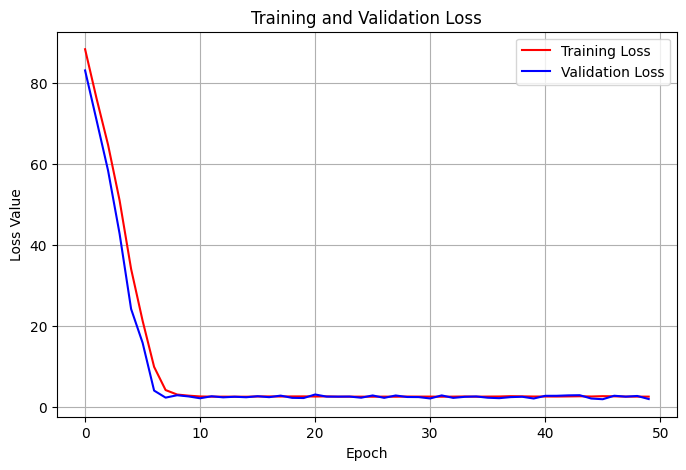

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 772ms/step
Fold 1 SBP MAE: 6.9809
Fold 1 DBP MAE: 1.7868

===== Fold 2 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 88.7570 - mae: 88.7570 - val_loss: 80.6573 - val_mae: 80.6573
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 77.2736 - mae: 77.2736 - val_loss: 68.1996 - val_mae: 68.1996
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 65.6585 - mae: 65.6585 - val_loss: 55.4294 - val_mae: 55.4294
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 51.9004 - mae: 51.9004 - val_loss: 39.0880 - val_mae: 39.0880
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 35.7387 - mae: 35.7387 - val_loss: 29.9211 - val_mae: 29.9211
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 26.3913 - mae: 26.3913 - val_loss: 16.6538 - val_mae: 16.6538
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 14.5391 - mae: 14.5391 - val_loss: 5.8730 - val_mae: 5.8730
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 6.1957 - mae: 6

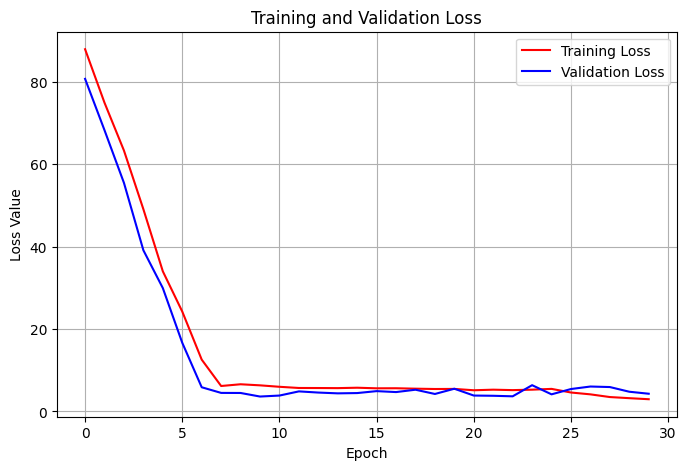

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 846ms/step
Fold 2 SBP MAE: 7.4590
Fold 2 DBP MAE: 3.4716

===== Fold 3 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 86.3433 - mae: 86.3433 - val_loss: 81.7345 - val_mae: 81.7345
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 72.1493 - mae: 72.1493 - val_loss: 65.3384 - val_mae: 65.3384
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 57.0203 - mae: 57.0203 - val_loss: 49.1154 - val_mae: 49.1154
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 39.8702 - mae: 39.8702 - val_loss: 29.1686 - val_mae: 29.1686
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 24.0113 - mae: 24.0113 - val_loss: 19.4441 - val_mae: 19.4441
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 14.1877 - mae: 14.1877 - val_loss: 8.9114 - val_mae: 8.9114
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 3.1107 - mae: 3.1107 - val_loss: 2.5985 - val_mae: 2.5985
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 2.8358 - mae: 2.835

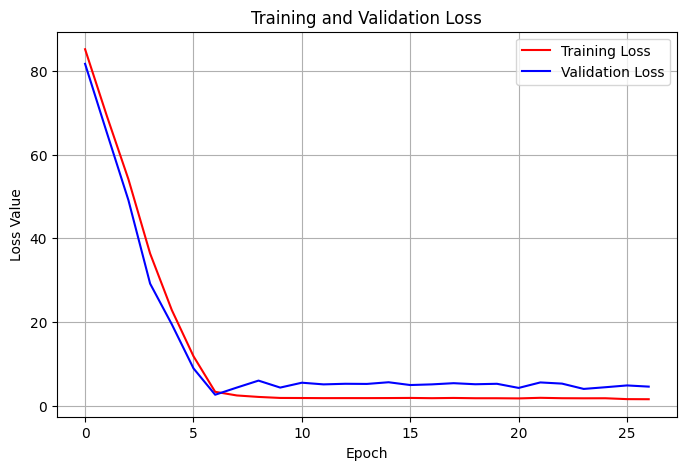

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step
Fold 3 SBP MAE: 1.7732
Fold 3 DBP MAE: 3.9530

===== Fold 4 =====
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 88.3188 - mae: 88.3188 - val_loss: 79.3434 - val_mae: 79.3434
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 76.1084 - mae: 76.1084 - val_loss: 66.5222 - val_mae: 66.5222
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 63.6391 - mae: 63.6391 - val_loss: 53.3580 - val_mae: 53.3580
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 49.5487 - mae: 49.5487 - val_loss: 36.8989 - val_mae: 36.8989
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 33.6299 - mae: 33.6299 - val_loss: 27.1120 - val_mae: 27.1120
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 24.5768 - mae: 24.5768 - val_loss: 14.3587 - val_mae: 14.3587
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 12.3183 - mae: 12.3183 - val_loss: 3.4209 - val_mae: 3.4209
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 3.6654 - mae: 3

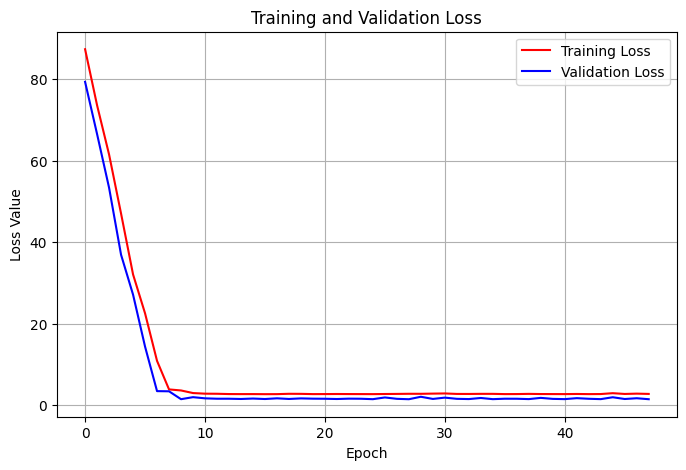

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step
Fold 4 SBP MAE: 4.6746
Fold 4 DBP MAE: 1.6927


In [7]:
# Fold 정의
folds = [
    (0, 300, 300, 400),
    (400, 700, 700, 800),
    (800, 1100, 1100, 1200),
    (1200, 1500, 1500, 1600)
]

input_shape = X.shape[1:] # (1250, 2)
sbp_mae_scores = []
dbp_mae_scores = []

for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(folds, 1):
    print(f"\n===== Fold {fold_idx} =====")

    # Train/Val/Test 분리
    X_train_full, y_train_full = X[train_start:train_end], y[train_start:train_end]
    X_val, y_val = X_train_full[-60:], y_train_full[-60:]     # 마지막 60개 → Validation
    X_train, y_train = X_train_full[:-60], y_train_full[:-60] # 나머지 → Train
    X_test, y_test = X[test_start:test_end], y[test_start:test_end]

    # StandardScaler 적용 (채널별로)
    scalers = []
    for ch in range(X.shape[2]):
        scaler = StandardScaler()
        # 2D로 reshape → (samples * timesteps, 1)
        X_train_ch = X_train[:, :, ch].reshape(-1, 1)
        scaler.fit(X_train_ch)
        scalers.append(scaler)

        # transform
        X_train[:, :, ch] = scaler.transform(X_train[:, :, ch].reshape(-1, 1)).reshape(X_train[:, :, ch].shape)
        X_val[:, :, ch]   = scaler.transform(X_val[:, :, ch].reshape(-1, 1)).reshape(X_val[:, :, ch].shape)
        X_test[:, :, ch]  = scaler.transform(X_test[:, :, ch].reshape(-1, 1)).reshape(X_test[:, :, ch].shape)

    # 모델 정의
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=5, padding='same', activation='relu'),
        Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        GRU(256, return_sequences=False),
        Dense(128, activation='relu'),
        # linear는 출력값 그대로 반환, 범위 제한 없음 → 혈압처럼 60~200까지 자유롭게 예측 가능
        Dense(2, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    # EarlyStopping (val_loss 기준)
    es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=1
    )

    plot_regression_history(history)

    y_pred = model.predict(X_test)
    sbp_mae, dbp_mae = sbp_dbp_mae(y_test, y_pred, fold_idx)
    sbp_mae_scores.append(sbp_mae)
    dbp_mae_scores.append(dbp_mae)

In [8]:
# 최종 평균/표준편차
print("\n===== Cross-Validation Result =====")
print("SBP MAE per fold:", [f"{v:.4f}" for v in sbp_mae_scores])
print("DBP MAE per fold:", [f"{v:.4f}" for v in dbp_mae_scores])

print(f"\nAverage SBP MAE: {np.mean(sbp_mae_scores):.4f}")
print(f"Std SBP MAE: {np.std(sbp_mae_scores):.4f}")

print(f"\nAverage DBP MAE: {np.mean(dbp_mae_scores):.4f}")
print(f"Std DBP MAE: {np.std(dbp_mae_scores):.4f}")


===== Cross-Validation Result =====
SBP MAE per fold: ['6.9809', '7.4590', '1.7732', '4.6746']
DBP MAE per fold: ['1.7868', '3.4716', '3.9530', '1.6927']

Average SBP MAE: 5.2219
Std SBP MAE: 2.2523

Average DBP MAE: 2.7260
Std DBP MAE: 1.0014
